# Relationships using genome distance vs expression distance

In our attempt to label modules as "mostly core", "mostly accessory" or "mixed". We found that most modules were "mixed" and some were "mostly accessory". We noticed that there were many modules that had only core genes, yet were not found to be signficanlty "mostly core" based on our Fisher's exact test due to the small size of the modules as well as the large imbalance in the number of core:accessory genes.

These small modules, which are due to operons, is biologically sensible but hard for us to apply statistics. We want to try to tease apart the co-expression relationships that are due to locations (i.e. being in the same operon) versus other functional reasons.

Our strategy is the following:
* For each accessory gene, is the 1-NN/2-NN/3-NN core or accessory? Same for core genes
* For each accessory gene, is the highest correlated/2nd-highest correlated/3rd highest correlated gene core or accessory? Same for core genes.

Then we can compare the trends seen in both

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scripts import paths, gene_relationships, annotations

random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# User params
method = "affinity"
offset_to_bin = 10

use_operon = True
sum_increment_to_use = 1

# Output filename
pao1_figure_filename = "PAO1_genome_expression_relationships_operon_corrected.svg"
pa14_figure_filename = "PA14_genome_expression_relationships_operon_corrected.svg"

### Import gene ids

In [3]:
# Import correlation matrix to get gene ids
pao1_corr_filename = paths.PAO1_CORR_RAW
pa14_corr_filename = paths.PA14_CORR_RAW

pao1_corr = pd.read_csv(pao1_corr_filename, sep="\t", index_col=0, header=0)
pa14_corr = pd.read_csv(pa14_corr_filename, sep="\t", index_col=0, header=0)

In [4]:
# Make a dataframe with gene ids
pao1_membership = pd.DataFrame(data=[], index=pao1_corr.index)
print(pao1_membership.shape)
pao1_membership.head()

(5563, 0)


""
PA0001
PA0002
PA0003
PA0004
PA0005


In [5]:
pa14_membership = pd.DataFrame(data=[], index=pa14_corr.index)
print(pa14_membership.shape)
pa14_membership.head()

(5887, 0)


""
PA14_55610
PA14_55600
PA14_55590
PA14_55580
PA14_55570


### Import and format operon data

In [6]:
pao1_operon_filename = paths.PAO1_OPERON
pa14_operon_filename = paths.PA14_OPERON

In [7]:
pao1_operon = annotations.load_format_operons(pao1_operon_filename)
pa14_operon = annotations.load_format_operons(pa14_operon_filename)

In [8]:
print(pao1_operon.shape)
pao1_operon.head()

(3569, 1)


,operon_name
locus_tag,
PA0001,dnaA-dnaN-recF-gyrB
PA0002,dnaA-dnaN-recF-gyrB
PA0003,dnaA-dnaN-recF-gyrB
PA0004,dnaA-dnaN-recF-gyrB
PA0005,PA0006-lptA


In [9]:
if use_operon:
    pao1_operon_expression_to_use = pao1_operon
    pa14_operon_expression_to_use = pa14_operon
else:
    pao1_operon_expression_to_use = None
    pa14_operon_expression_to_use = None

### Map core/accessory labels to genes

In [10]:
# Read in expression data
pao1_expression_filename = paths.PAO1_COMPENDIUM
pa14_expression_filename = paths.PA14_COMPENDIUM

In [11]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

In [12]:
(
    pao1_arr,
    pa14_arr,
    pao1_core,
    pao1_acc,
    pa14_core,
    pa14_acc,
) = annotations.map_core_acc_annot(
    pao1_membership,
    pa14_membership,
    pao1_expression_filename,
    pa14_expression_filename,
    pao1_annot_filename,
    pa14_annot_filename,
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5357
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 530


In [13]:
print(pao1_arr.shape)
pao1_arr.head()

(5563, 1)


,core/acc
PA0001,core
PA0002,core
PA0003,core
PA0004,core
PA0005,core


In [14]:
pao1_arr.tail()

,core/acc
PA5566,core
PA5567,core
PA5568,core
PA5569,core
PA5570,acc


In [15]:
print(pa14_arr.shape)
pa14_arr.head()

(5887, 1)


,core/acc
PA14_00010,core
PA14_00020,core
PA14_00030,core
PA14_00050,core
PA14_00060,core


In [16]:
pa14_arr.tail()

,core/acc
PA14_73370,core
PA14_73390,core
PA14_73400,core
PA14_73410,core
PA14_73420,core


In [17]:
# Fill in index of operon_df to include all genes
all_pao1_gene_ids = pao1_arr.index
all_pa14_gene_ids = pa14_arr.index

# Get missing gene ids
missing_pao1_gene_ids = set(all_pao1_gene_ids).difference(pao1_operon.index)
missing_pa14_gene_ids = set(all_pa14_gene_ids).difference(pa14_operon.index)

# Make dataframe with missing gene ids with np.nan values for operon_name
missing_pao1_gene_df = pd.DataFrame(
    data=np.nan, index=list(missing_pao1_gene_ids), columns=["operon_name"]
)
missing_pa14_gene_df = pd.DataFrame(
    data=np.nan, index=list(missing_pa14_gene_ids), columns=["operon_name"]
)

pao1_operon_genome_dist = pao1_operon.append(missing_pao1_gene_df)
pa14_operon_genome_dist = pa14_operon.append(missing_pa14_gene_df)

pao1_operon_genome_dist = pao1_operon_genome_dist.loc[all_pao1_gene_ids]
pa14_operon_genome_dist = pa14_operon_genome_dist.loc[all_pa14_gene_ids]

In [18]:
print(pao1_operon_genome_dist.shape)
pao1_operon_genome_dist.tail()

(5563, 1)


,operon_name
PA5566,NaN
PA5567,PA5568-PA5567
PA5568,PA5568-PA5567
PA5569,rpmH-rnpA
PA5570,rpmH-rnpA


In [19]:
print(pa14_operon_genome_dist.shape)
pa14_operon_genome_dist.tail()

(5887, 1)


,operon_name
PA14_73370,gidA-gidB-soj-parB
PA14_73390,NaN
PA14_73400,PA14_73410-trmE
PA14_73410,PA14_73410-trmE
PA14_73420,NaN


In [20]:
if use_operon:
    pao1_operon_genome_to_use = pao1_operon_genome_dist
    pa14_operon_genome_to_use = pa14_operon_genome_dist
else:
    pao1_operon_genome_to_use = None
    pa14_operon_genome_to_use = None

## Find relationships using genome distance

In [21]:
genome_dist_counts_pao1 = gene_relationships.get_relationship_in_genome_space(
    pao1_arr, offset_to_bin, pao1_operon_genome_to_use
)
genome_dist_counts_pa14 = gene_relationships.get_relationship_in_genome_space(
    pa14_arr, offset_to_bin, pa14_operon_genome_to_use
)

In [22]:
genome_dist_counts_pao1.head()

,gene start,gene compare,offset,total
0,acc,acc,1,108.0
1,acc,acc,2,128.0
2,acc,acc,3,110.0
3,acc,acc,4,102.0
4,acc,acc,5,84.0


In [23]:
genome_dist_counts_pa14.head()

,gene start,gene compare,offset,total
0,acc,acc,1,374.0
1,acc,acc,2,484.0
2,acc,acc,3,496.0
3,acc,acc,4,490.0
4,acc,acc,5,472.0


## Find relationships using expression distance

In [24]:
# Correlation matrix files
pao1_corr_filename = paths.PAO1_CORR_LOG_SPELL
pa14_corr_filename = paths.PA14_CORR_LOG_SPELL

In [25]:
# Load correlation data
pao1_corr = pd.read_csv(pao1_corr_filename, sep="\t", index_col=0, header=0)
pa14_corr = pd.read_csv(pa14_corr_filename, sep="\t", index_col=0, header=0)

In [26]:
%%time
expression_dist_counts_pao1_acc = (
    gene_relationships.get_relationship_in_expression_space(
        pao1_corr,
        pao1_acc,
        pao1_arr,
        offset_to_bin,
        pao1_operon_expression_to_use,
        sum_increment_to_use,
    )
)

CPU times: user 2min 17s, sys: 0 ns, total: 2min 17s
Wall time: 2min 17s


In [27]:
%%time
expression_dist_counts_pao1_core = (
    gene_relationships.get_relationship_in_expression_space(
        pao1_corr,
        pao1_core,
        pao1_arr,
        offset_to_bin,
        pao1_operon_expression_to_use,
        sum_increment_to_use,
    )
)

CPU times: user 2h 31min 13s, sys: 2min 41s, total: 2h 33min 54s
Wall time: 2h 33min 54s


In [28]:
%%time
expression_dist_counts_pa14_acc = (
    gene_relationships.get_relationship_in_expression_space(
        pa14_corr,
        pa14_acc,
        pa14_arr,
        offset_to_bin,
        pa14_operon_expression_to_use,
        sum_increment_to_use,
    )
)

CPU times: user 7min 6s, sys: 124 µs, total: 7min 6s
Wall time: 7min 6s


In [29]:
%%time
expression_dist_counts_pa14_core = (
    gene_relationships.get_relationship_in_expression_space(
        pa14_corr,
        pa14_core,
        pa14_arr,
        offset_to_bin,
        pa14_operon_expression_to_use,
        sum_increment_to_use,
    )
)

CPU times: user 2h 40min 25s, sys: 2min 50s, total: 2h 43min 16s
Wall time: 2h 43min 15s


In [30]:
expression_dist_counts_pao1_acc.head()

,offset,gene type,total
0,1,acc,122.0
1,2,acc,109.0
2,3,acc,110.0
3,4,acc,104.0
4,5,acc,93.0


In [31]:
expression_dist_counts_pao1_core.head()

,offset,gene type,total
0,1,acc,81.0
1,2,acc,85.0
2,3,acc,96.0
3,4,acc,106.0
4,5,acc,105.0


In [32]:
expression_dist_counts_pa14_acc.head()

,offset,gene type,total
0,1,acc,317.0
1,2,acc,321.0
2,3,acc,315.0
3,4,acc,312.0
4,5,acc,301.0


In [33]:
expression_dist_counts_pa14_core.head()

,offset,gene type,total
0,1,acc,168.0
1,2,acc,225.0
2,3,acc,206.0
3,4,acc,212.0
4,5,acc,217.0


### Plot

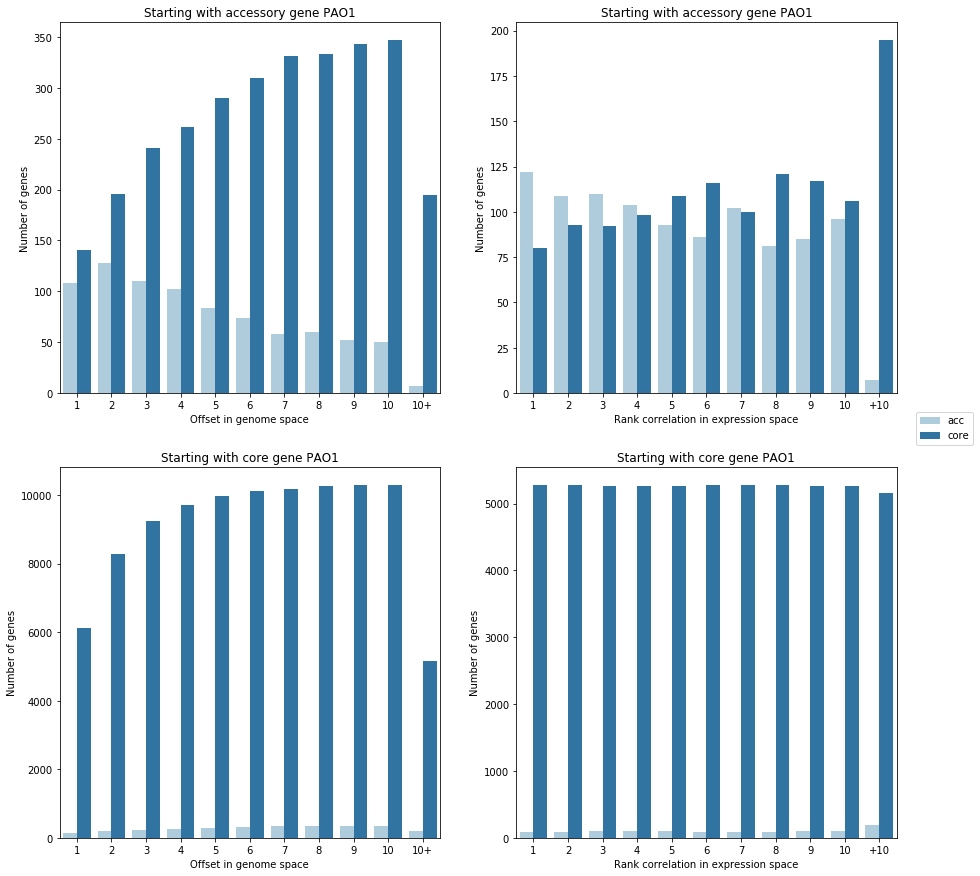

In [34]:
# Plot PAO1 trends
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

fig = sns.barplot(
    data=genome_dist_counts_pao1[genome_dist_counts_pao1["gene start"] == "acc"],
    x="offset",
    y="total",
    hue="gene compare",
    ax=axes[0][0],
    palette=sns.color_palette("Paired"),
)
fig.legend_.remove()
fig.set_title("Starting with accessory gene PAO1")
fig.set_ylabel("Number of genes")
fig.set_xlabel("Offset in genome space")

fig = sns.barplot(
    data=genome_dist_counts_pao1[genome_dist_counts_pao1["gene start"] == "core"],
    x="offset",
    y="total",
    hue="gene compare",
    ax=axes[1][0],
    palette=sns.color_palette("Paired"),
)
fig.legend_.remove()
fig.set_title("Starting with core gene PAO1")
fig.set_ylabel("Number of genes")
fig.set_xlabel("Offset in genome space")

fig = sns.barplot(
    data=expression_dist_counts_pao1_acc,
    x="offset",
    y="total",
    hue="gene type",
    ax=axes[0][1],
    palette=sns.color_palette("Paired"),
)
fig.legend_.remove()
fig.set_title("Starting with accessory gene PAO1")
fig.set_ylabel("Number of genes")
fig.set_xlabel("Rank correlation in expression space")

fig = sns.barplot(
    data=expression_dist_counts_pao1_core,
    x="offset",
    y="total",
    hue="gene type",
    ax=axes[1][1],
    palette=sns.color_palette("Paired"),
)
fig.legend_.remove()
fig.set_title("Starting with core gene PAO1")
fig.set_ylabel("Number of genes")
fig.set_xlabel("Rank correlation in expression space")


# Note: We are creating a single global legend that apply
# to all the facets of this figure. To do this using
# matplotlib, we need to be a little creative here
# and add the legend to a new location that is applied
# to the figure and then remove the legend from the facet.
plt.legend(bbox_to_anchor=(1.05, 1.15), loc=2, borderaxespad=0.0)

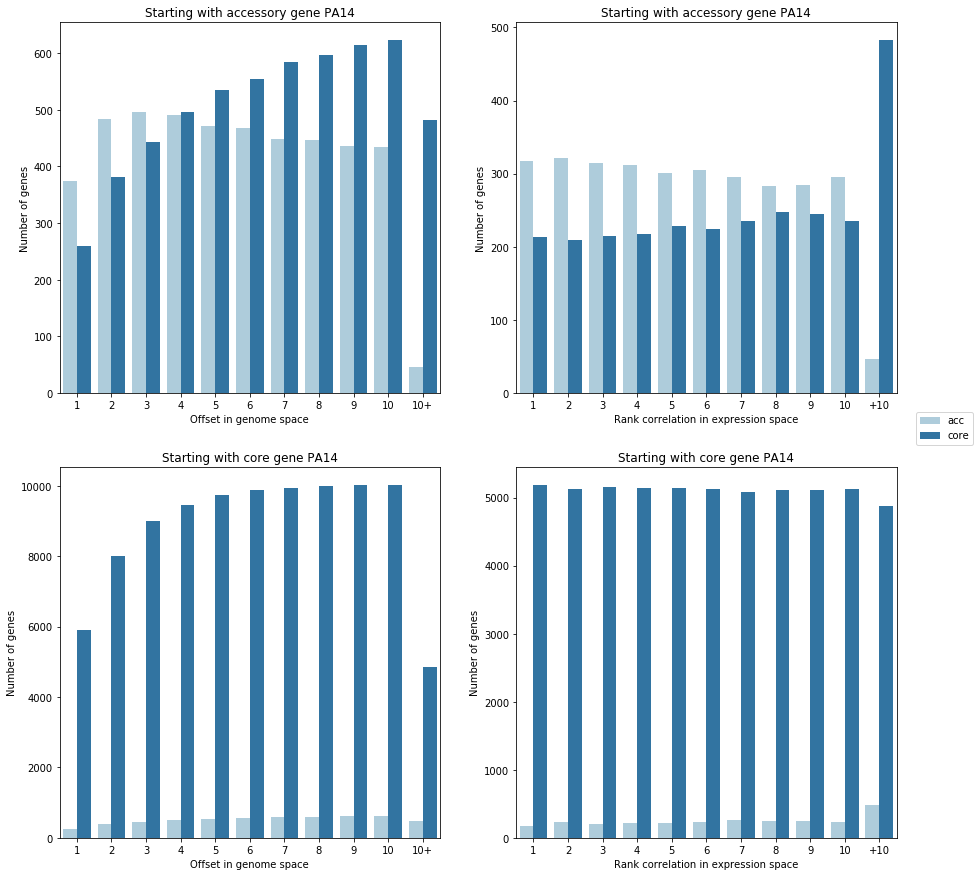

In [35]:
# Plot PA14 trends
fig2, axes2 = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

fig2 = sns.barplot(
    data=genome_dist_counts_pa14[genome_dist_counts_pa14["gene start"] == "acc"],
    x="offset",
    y="total",
    hue="gene compare",
    ax=axes2[0][0],
    palette=sns.color_palette("Paired"),
)
fig2.legend_.remove()
fig2.set_title("Starting with accessory gene PA14")
fig2.set_ylabel("Number of genes")
fig2.set_xlabel("Offset in genome space")

fig2 = sns.barplot(
    data=expression_dist_counts_pa14_acc,
    x="offset",
    y="total",
    hue="gene type",
    ax=axes2[0][1],
    palette=sns.color_palette("Paired"),
)
fig2.legend_.remove()
fig2.set_title("Starting with accessory gene PA14")
fig2.set_ylabel("Number of genes")
fig2.set_xlabel("Rank correlation in expression space")

fig2 = sns.barplot(
    data=genome_dist_counts_pa14[genome_dist_counts_pa14["gene start"] == "core"],
    x="offset",
    y="total",
    hue="gene compare",
    ax=axes2[1][0],
    palette=sns.color_palette("Paired"),
)
fig2.legend_.remove()
fig2.set_title("Starting with core gene PA14")
fig2.set_ylabel("Number of genes")
fig2.set_xlabel("Offset in genome space")

fig2 = sns.barplot(
    data=expression_dist_counts_pa14_core,
    x="offset",
    y="total",
    hue="gene type",
    ax=axes2[1][1],
    palette=sns.color_palette("Paired"),
)
fig2.legend_.remove()
fig2.set_title("Starting with core gene PA14")
fig2.set_ylabel("Number of genes")
fig2.set_xlabel("Rank correlation in expression space")

plt.legend(bbox_to_anchor=(1.05, 1.15), loc=2, borderaxespad=0.0)

In [36]:
# Save figures using operons
# Save figures not using operons
# Save figure with rolling sum and operons
# Save figure with rolling sum not using operons
fig.figure.savefig(
    pao1_figure_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

fig2.figure.savefig(
    pa14_figure_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

**Takeaway:**

In genome space:
* The closest non co-operonic neighbor to an accessory gene is a core gene for PAO1, but is an accessory gene for PA14
* Including co-operonic genes, accessory genes are clustered together on the genome (i.e. clustered with other accessory genes compared to core genes), which is known: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3008168/
* Starting with a core gene, at any distance you find core genes including and not including co-operonic genes.
* The x-axis indicates (left panel of plots) is the number of nearest neighbors (NN), determined based on the gene id that is sorted.

In expression space:
* Accessory genes are more likely to be highly co-expressed with other accessory genes, even accessory genes farther away (some coordination outside of location). This relationship is stronger in PA14 than PAO1 (i.e. accessory genes are more highly correlated with other accessory genes at farther distances in PA14). I wonder why this is.
* Core genes are highly correlated with other core genes, again, this may be due to the fact that there are so many more core genes.
* The x-axis(right panels of plots) is the number of correlated genes (i.e. 1=top most correlated gene, 2 =2nd most correlated gene)

Note:
* The distance calculation in genome space is bi-directional (i.e. it considers genes that are 1-NN to the left and right) so each starting gene has a count of 1-2. Whereas in expression space, we are only looking for the most correlated gene, so each starting gene has a count of 1. This explains why the range for the expression space plots are roughly half of the genome distance plots. To correct for this, there is an option to sum the counts across the 2 most highly correlated genes. The trends are consistent using an increment of 1 vs 2.
* There is a drop off in the `10+` column for genome distance. This is because as we consider farther away genes, we lose the ability to consider in both directions and there are fewer genes at that far a distance. Should we adjust for this in our calculation?

Some things to note about this analysis that may need to be updated:
* There are some operons that have multiple annotations, which one should we choose? Should we drop these from the analysis? Should we curate these to determine which ones?
* When we sorted the gene ids, we found that PAO1 incremented by 1 and PA14 incremented by 10 or 20, are we missing genes for PA14? How much will this change our genome dist analysis?